In [1094]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [1306]:
# Import the data and get a quick glance at what it looks like
df = pd.read_csv("/Users/brielle/Documents/Jupyter/Data/Canada_Retail_Sales_per_Yr.csv")
df

,Period,Retail_trade,E_shopping,Retail_E_commerce
0,2016-01-01,37415147,679612,877354
1,2016-02-01,36815980,616598,789553
2,2016-03-01,42763737,681191,865677
3,2016-04-01,46155952,686764,916710
4,2016-05-01,48783412,681192,916244
...,...,...,...,...
66,2021-07-01,60103496,1842253,2834922
67,2021-08-01,58829377,1996704,2977037
68,2021-09-01,57634235,2237769,3244009
69,2021-10-01,58946550,2286815,3336382


In [1307]:
# We just want to be looking at 1 Sales at a time so we're going to just select Period and E_shopping

# If we want to look at the E_shopping column
df_eshop = df[['Period', 'E_shopping']]
# Rename the E_shopping column by replacing the old one with Sales
df_eshop.rename({'Period': 'Period', 'E_shopping': 'Sales'}, axis = 1, inplace = True)

# OR if we want to look at Retail_E_commerce we can uncomment the lines below
# df_eshop = df[['Period', 'Retail_E_commerce']]
# # Rename the Retail_E_commerce column by replacing the old one with Sales
# df_eshop.rename({'Period': 'Period', 'Retail_E_commerce': 'Sales'}, axis = 1, inplace = True)

df_eshop

,Period,Sales
0,2016-01-01,679612
1,2016-02-01,616598
2,2016-03-01,681191
3,2016-04-01,686764
4,2016-05-01,681192
...,...,...
66,2021-07-01,1842253
67,2021-08-01,1996704
68,2021-09-01,2237769
69,2021-10-01,2286815


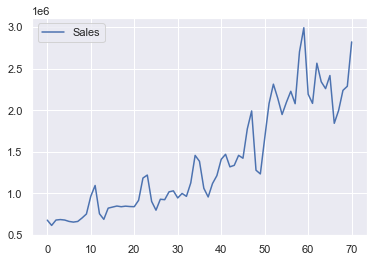

In [1308]:
# Plot the data really quickly
df_eshop.plot()
plt.show()

In [1309]:
# Date column (aka ds) must be in date time format
from pandas import to_datetime
# Set the display format to not have decimals
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Set the Period column to be a data frame index and to be in the date time format
df_eshop.index = pd.to_datetime(df_eshop['Period'], format = '%Y-%m-%d')

# We do not need the period column anymore as we're using the index now
del df_eshop['Period']

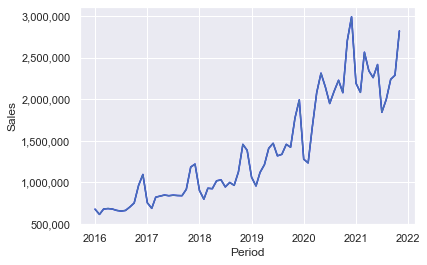

In [1310]:
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

# Plot the Period and Sales data
fig, ax = plt.subplots()
ax.plot(df_eshop.index, df_eshop['Sales'], color = 'blue')
plt.ylabel('Sales')
plt.xlabel('Period')
plt.xticks(rotation = 0) # Can rotate the dates on x axis if we want
ax.plot(df_eshop.index, df_eshop['Sales'])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) # Edit the format so that it is thousands with ','
plt.show()

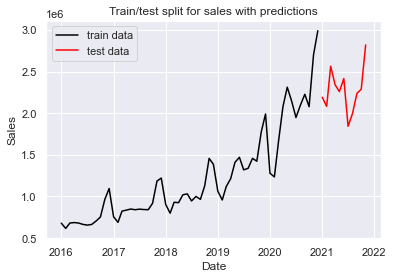

In [1311]:
# Split out the training and the test data. Training data will be 2016-2020 and test is 2021

# Select the dates before 2021 as the training data
train = df_eshop[df_eshop.index < pd.to_datetime("2020-12-02", format = '%Y-%m-%d')]

# Select the dates after 2021 as the test data
test = df_eshop[df_eshop.index > pd.to_datetime("2020-12-02", format = '%Y-%m-%d')]

# Plot the train and test data in different colours to differentiate them
plt.plot(train, color = 'black', label = 'train data')
plt.plot(test, color = 'red', label = 'test data')
# Add the labels
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation = 0) # Can rotate the dates on x axis if we want 
plt.title('Train/test split for sales with predictions')
plt.legend() # Add the legend so we know what colours mean what
plt.plot()
plt.show()

In [1312]:
# If we want, we can view the test and train data with corresponding dates
# print(train)
# print(test)

In [1313]:
from statsmodels.tsa.statespace.sarimax import SARIMAX as sarimax

# Define the input
y = train['Sales']

In [1314]:
# Determine the parameters to put in the SARIMAX order = 
import itertools

# Define the p,d,q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Generate all different combos of p,d,q triplets
# pdq = list(itertools.product(p,d,q)) # Use this if we want to run through all iterations of pdq. 
pdq = (1,0,1) # for now we just want pdq = (1,0,1)

# Generate all different combos of seasonal p, d, q triplets
# Use 12 because we have separated by YYYY-MM and there's 12 months per year
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [1315]:
# Run through the model with the different parameters to see which is best
from sklearn.metrics import mean_squared_error
from math import sqrt
from IPython.display import clear_output

warnings.filterwarnings('ignore') # ignore warning messages

params_rmse = {}

# if we wanted to run through all pdf from above we would do a for loop for all pdq params too
# for param in pdq: 

for param_seasonal in seasonal_pdq:
    try:
        
        # we would replace order = pdq with order = param if we were running through all iterations of pdq
        
        # Define the model and its paramters. order and seasonal_order will change as we run through the loop
        ARMAmodel = sarimax(y, order = pdq, seasonal_order = param_seasonal,
                                         enforce_stationarity = True,
                                         enforce_invertibility = True)
        # Fit the model
        model2 = ARMAmodel.fit()

        # we would replace pdq with param if we were running through all iterations of pdq
        print('ARIMA{}x{}12 - AIC:{}'.format(pdq, param_seasonal, results.aic))
        arima_params = 'ARIMA{}x{}12'.format(pdq, param_seasonal, results.aic)

        # Use the model to predict the test data
        y_pred = model2.get_forecast(len(test.index))
        
        # alpha = 0.05 means 95% prediction interval suggests high likely (95%) that the real observation 
        # is in the range
        y_pred_df = y_pred.conf_int(alpha = 0.05)
        
        # Generate the predictions into its own df
        y_pred_df['Predictions'] = model2.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
        y_pred_df.index = test.index
        y_pred_out = y_pred_df['Predictions']

        # Calculate the Root Mean Squared Errors for all of the parameters
        model_rmse = sqrt(mean_squared_error(test['Sales'].values, y_pred_df['Predictions']))

        print('*************************************************************************')
        print('RMSE is: ', f"{model_rmse:,.0f}")

        # Add all parameters and RMSE to a dictionary so we can find which one is smallest and use that in our model
        case = {str(arima_params) : model_rmse}
        params_rmse.update(case)

    except:
        continue

# Clear the output
clear_output()

In [1316]:
# Find the minimum RMSE and its parameters so that we can use it in the final model 

# the seasonal_order = (0, 0, 0, 12) does not provide enough detail so we want to delete it from consideration.
# Even if it has the lowest RMSE, we do not want it showing up because we will not use it in the model anyway
del params_rmse['ARIMA(1, 0, 1)x(0, 0, 0, 12)12']
# print(params_rmse)

# Create a list of values and parameters from our params_rmse dictionary
list_of_params = list(params_rmse.keys())
list_of_values = list(params_rmse.values())

# Find the minimum RMSE from the values in our dictionary
min_rmse = min(list_of_values)
# print(min_rmse)

# Find the index of our minimum RMSE to see what the key is aka the ARIMA Parameters corresponding to the min RMSE
min_index = list_of_values.index(min_rmse)
# print(min_index)

print('Min RMSE is : ', f"{min_rmse:,.0f}") # format the RMSE to remove decimals and sepate thousands by , 

# Find the key aka the ARIMA Parameters corresponding to the min RMSE
param_for_min = list_of_params[min_index]
print('For the parameters: ')
print(param_for_min)

Min RMSE is :  415,115
For the parameters: 
ARIMA(1, 0, 1)x(0, 1, 0, 12)12


In [1317]:
# Define the model
# pass in the order parameters with the lowest RMSE found above. We can change these to see different results

# Define the model
# ARMAmodel = sarimax(y, order = (1,0,1), seasonal_order = (0,1,1,12)) # Could chose this or others if we want
ARMAmodel = sarimax(y, order = (1,0,1), seasonal_order = (0,1,0,12), enforce_stationarity = True,
                                         enforce_invertibility = True)

# Fit the model with the chosen parameters (ideally the ones that give us the min RMSE found above)
model = ARMAmodel.fit() 

# Clear the output
clear_output()

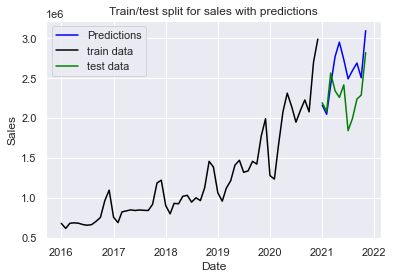

In [1318]:
# Use the model to predict the test data
y_pred = model.get_forecast(len(test.index))

# alpha = 0.05 means 95% prediction interval suggests high likely (95%) that the real observation is in the range
y_pred_df = y_pred.conf_int(alpha = 0.05)

# Generate the predictions into its own df
y_pred_df['Predictions'] = model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df['Predictions']

# Plot the Train data, test data and the models predictions in different colours to differenciate them
plt.plot(y_pred_out, color = 'blue', label = 'Predictions')
plt.plot(train, color = 'black', label = 'train data')
plt.plot(test, color = 'green', label = 'test data')
# Add the labels
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation = 0) # Can rotate the dates on x axis if we want 
plt.title('Train/test split for sales with predictions')
plt.legend() # Add the legend so we know what colours mean what
plt.plot()
plt.show()

In [1319]:
# View the Predictions vs the actual sales values and we can compare the 2
list_of_preds = list(y_pred_df['Predictions'].values)

print(['{:.0f}'.format(item) for item in list_of_preds])
print('')
print(test['Sales'].values)

['2160105', '2047112', '2413074', '2770734', '2950304', '2732485', '2491075', '2596447', '2689078', '2504443', '3094060']

[2191179. 2081430. 2563464. 2340922. 2258594. 2415733. 1842253. 1996704.
 2237769. 2286815. 2819238.]


In [1320]:
# Evaluate the performance of the model using Root Mean Squared Error (RMSE)

# We want to see clearly what the RMSE is for this particular model
model_rmse = sqrt(mean_squared_error(test['Sales'].values, y_pred_df['Predictions']))

print('RMSE is: ', f"{model_rmse:,.0f}") # format so that we dont see decimals and separate thousands by ,


RMSE is:  415,115


In [1321]:
# Create a list of the future dates so that we can predict them
# future starts with 2021-12 because that value wasnt in the original data and we still want it added
from dateutil.relativedelta import relativedelta

# The max date in the data 
max_date = max(df_eshop.index)
# The start date needs to be the month after the last date we have in the data
start_date = max_date + relativedelta(months = 1)
# The end data is whatever we chose. We can look at 2 years from now, 3 years 10 years whatever
end_date = '2023-12'

# Create a dataframe for the future so that the model uses that to make its predictions
future = pd.date_range(start_date, end_date, freq = 'MS')
print(future)
future = pd.DataFrame(future)
print(future)

DatetimeIndex(['2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01'],
              dtype='datetime64[ns]', freq='MS')
            0
0  2021-12-01
1  2022-01-01
2  2022-02-01
3  2022-03-01
4  2022-04-01
5  2022-05-01
6  2022-06-01
7  2022-07-01
8  2022-08-01
9  2022-09-01
10 2022-10-01
11 2022-11-01
12 2022-12-01
13 2023-01-01
14 2023-02-01
15 2023-03-01
16 2023-04-01
17 2023-05-01
18 2023-06-01
19 2023-07-01
20 2023-08-01
21 2023-09-01
22 2023-10-01
23 2023-11-01
24 2023-12-01


In [1322]:
# Make sure the future column is in Datetime format and make it the index which is what the time series forecase uses
future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])
future.index = future['ds']
future.index

DatetimeIndex(['2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [1323]:
# Use the model to predict the forecast
forecast = model.get_forecast(len(future.index))

# alpha = 0.05 means 95% prediction interval suggests high likely (95%) that the real observation is in the range
forecast_df = forecast.conf_int(alpha = 0.05)

# Generate the predictions into its own df
forecast_df['Predictions'] = model.predict(start = forecast_df.index[0], end = forecast_df.index[-1])
forecast_df.index = future.index
forecast_out = forecast_df['Predictions']
forecast_out

ds
2021-12-01   2160105
2022-01-01   2047112
2022-02-01   2413074
2022-03-01   2770734
2022-04-01   2950304
2022-05-01   2732485
2022-06-01   2491075
2022-07-01   2596447
2022-08-01   2689078
2022-09-01   2504443
2022-10-01   3094060
2022-11-01   3352583
2022-12-01   2495285
2023-01-01   2356365
2023-02-01   2698406
2023-03-01   3033994
2023-04-01   3193200
2023-05-01   2956592
2023-06-01   2697846
2023-07-01   2787224
2023-08-01   2865098
2023-09-01   2666847
2023-10-01   3243901
2023-11-01   3490833
2023-12-01   2622842
Name: Predictions, dtype: float64

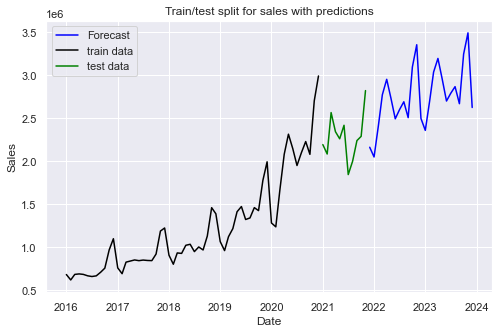

In [1324]:
# Plot the Forecast with the previous data we had so we can see how it is trending 

# Set the dimensions of the plot
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(5)

# Add the data to the plot. We want the test data, train data and forecast. And them to be different colours
plt.plot(forecast_out, color = 'blue', label = 'Forecast')
plt.plot(train, color = 'black', label = 'train data')
plt.plot(test, color = 'green', label = 'test data')

# Add the labels
plt.ylabel('Sales')
plt.xlabel('Date')
plt.xticks(rotation = 0) # Can rotate the dates on x axis if we want 
plt.title('Train/test split for sales with predictions')
plt.legend() # Add the legend so we know what colours mean what
plt.plot()
plt.show()